<a href="https://colab.research.google.com/github/stochasticats/plantpathologyfgvc7-keras-deeplearning/blob/master/Plant_Pathology_FGVC7_Identifying_foliar_disease_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Pathology 2020 - FGVC7
Identify the category of foliar diseases in apple trees

Kaggle competition - https://www.kaggle.com/c/plant-pathology-2020-fgvc7/submit

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
import os
import shutil
import matplotlib.pyplot as plt

2.3.0


#Loading Data and Preprocessing
Here we load the data and take a look at what we're dealing with.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -uq "/content/drive/My Drive/plant-pathology-2020-fgvc7.zip"

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

target = train[['healthy', 'multiple_diseases', 'rust', 'scab']]
test_ids = test['image_id']

train_len = train.shape[0]
test_len = test.shape[0]

train.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [5]:
print("Shape of train data: " + str(train.shape))
print("Shape of test data: " + str(test.shape))

Shape of train data: (1821, 5)
Shape of test data: (1821, 1)


In [6]:
train_len = train.shape[0]
test_len = test.shape[0]
print(train_len)
print(test_len) 

1821
1821


Let's see the distribution of images in terms of the targets/labels.

In [7]:
print(train.describe())
print(test.describe())

           healthy  multiple_diseases         rust         scab
count  1821.000000        1821.000000  1821.000000  1821.000000
mean      0.283361           0.049973     0.341571     0.325096
std       0.450754           0.217948     0.474367     0.468539
min       0.000000           0.000000     0.000000     0.000000
25%       0.000000           0.000000     0.000000     0.000000
50%       0.000000           0.000000     0.000000     0.000000
75%       1.000000           0.000000     1.000000     1.000000
max       1.000000           1.000000     1.000000     1.000000
         image_id
count        1821
unique       1821
top     Test_1186
freq            1


Ah, we see the multiple_diseases label has drastically less images than the rest of the labels. Once we load the images in raw data form, we'll use scikitlearn to randomly over sample so we can fix this class imbalance.

Now let's load the image data.

In [8]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tqdm.notebook import tqdm

path = '/content/images/'
size = 224

train_images = np.ndarray(shape=(train_len, size, size, 3))
for i in tqdm(range(train_len)):
  img = load_img(path + f'Train_{i}.jpg', target_size=(size, size))
  train_images[i] = np.uint8(img_to_array(img))

test_images = np.ndarray(shape=(test_len, size, size, 3))
for i in tqdm(range(test_len)):
  img = load_img(path + f'Test_{i}.jpg', target_size=(size, size))
  test_images[i] = np.uint8(img_to_array(img))

train_images.shape, test_images.shape

((1821, 224, 224, 3), (1821, 224, 224, 3))

In [9]:
print(train_images.shape)
print(test_images.shape)

(1821, 224, 224, 3)
(1821, 224, 224, 3)


Here we see the images are in raw data form, with three matrices for RGB format. We'll rescale later on as well.

Let's take a look at what the images look like.

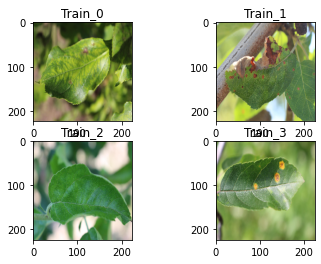

<Figure size 432x288 with 0 Axes>

In [10]:
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.title(train['image_id'][i])
	plt.imshow(np.uint8(train_images[i]))
plt.show()
plt.savefig('train_images.png')

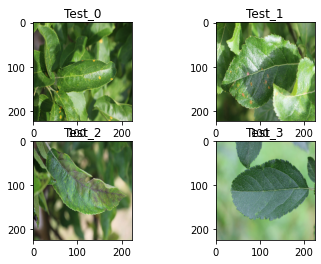

<Figure size 432x288 with 0 Axes>

In [11]:
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.title(test['image_id'][i])
	plt.imshow(np.uint8(test_images[i]))
plt.show()
plt.savefig('test_images.png')

Let's split out data into train and test sets for the model.

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_images, target.to_numpy(), test_size=0.1, random_state=289) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1638, 224, 224, 3), (183, 224, 224, 3), (1638, 4), (183, 4))

Now use RandomOverSampler to fix our class imbalance in the multiple diseases class.

In [13]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=289)

x_train, y_train = ros.fit_resample(x_train.reshape((-1, size * size * 3)), y_train)
x_train = x_train.reshape((-1, size, size, 3))
x_train.shape, y_train.shape

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((2240, 224, 224, 3), (2240, 4))

In [14]:
import gc

del train_images
gc.collect()

16140

Now we prepare the data for going into a Keras deep learning model. Here I use the ImageDataGenerator to also give us more images by using the parameters to rotate, horizontally flip, and vertically flip. Also the image is rescaled by 1/255 to normalize the raw data so that the activation functions work properly.

In [15]:
from keras_preprocessing.image import ImageDataGenerator

batch_size = 8

train_datagen = ImageDataGenerator(samplewise_center = True,
                                   samplewise_std_normalization = True,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range=20)

train_generator = train_datagen.flow(
    x = x_train, 
    y = y_train,
    batch_size = batch_size)

validation_datagen = ImageDataGenerator(samplewise_center = True,
                                        samplewise_std_normalization = True)

validation_generator = validation_datagen.flow(
    x = x_test, 
    y = y_test,
    batch_size = batch_size)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


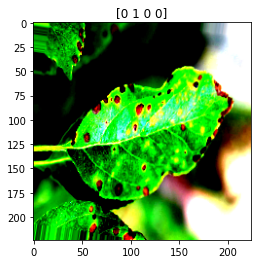

In [16]:
idx = np.random.randint(8)
x, y = train_generator.__getitem__(idx)
plt.title(y[idx])
plt.imshow(x[idx])
plt.savefig('processed_img.png')

# Model
Let's create the model. Here I build a custom model consisting of convolution layers of ascending filter size, a flatten, and 2 dense layers with the last activation function being the softmax so we can predict between four classes.

In [29]:
pre_trained = tf.keras.applications.EfficientNetB7(include_top = False, weights = 'imagenet', input_shape = (size, size, 3))

def create_model():
    model = tf.keras.Sequential([
      pre_trained,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(4, activation='softmax')
      ])
    model.compile(
        loss = 'kullback_leibler_divergence', 
        optimizer = 'adam', 
        metrics = ['accuracy'])
    return model

model = create_model()

model.summary()

258080768/258076736 [==============================] - 7s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2560)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               655616    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
Total params: 64,770,011
Trainable params: 64,459,284
Non-trainable params: 310,727
_________________________________________________________________


In [30]:
epochs = 20
steps_per_epoch = x_train.shape[0] // batch_size
validation_steps = x_test.shape[0] // batch_size
print(steps_per_epoch)

280


Let's set up some callbacks. 
Callbacks:

**EarlyStopping** - stop early if the validation loss has stopped improving

**ModelCheckpoint** - save the model every epoch and save the best weights

**ReduceLROnPlateau** - reduce learning rate when validation loss has stopped improving

**LearningRateScheduler** - set learning rate to ramp up during early epochs



Learning rate per epoch:


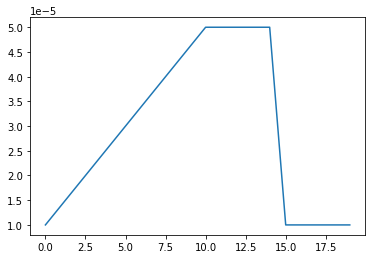

In [31]:
es = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('model.hdf5', save_best_only=True, verbose=0)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1)

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 10
sustain_epochs = 5
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return min_lr
    
lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(epochs)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

Now that we've built the model and set up our model parameters, let's train it and see what happens!

In [32]:
history = model.fit(
    x = train_generator,  
    validation_data = validation_generator,
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    verbose=1,
    callbacks=[es, lr, mc, rlr])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
280/280 [==============================] - 112s 400ms/step - loss: 1.3607 - accuracy: 0.3304 - val_loss: 1.3323 - val_accuracy: 0.3750

Epoch 00002: LearningRateScheduler reducing learning rate to 1.4000000000000001e-05.
Epoch 2/20
280/280 [==============================] - 107s 383ms/step - loss: 1.1165 - accuracy: 0.6107 - val_loss: 1.1656 - val_accuracy: 0.6420

Epoch 00003: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 3/20
280/280 [==============================] - 107s 383ms/step - loss: 0.6438 - accuracy: 0.7839 - val_loss: 0.3492 - val_accuracy: 0.9091

Epoch 00004: LearningRateScheduler reducing learning rate to 2.2000000000000003e-05.
Epoch 4/20
280/280 [==============================] - 108s 386ms/step - loss: 0.3862 - accuracy: 0.8714 - val_loss: 0.2238 - val_accuracy: 0.9489

Epoch 00005: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epo

# Results
We plot the train and validation accuracy and loss to see how the model did over the epochs.

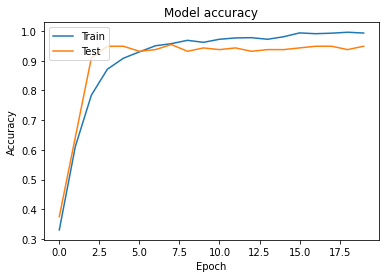

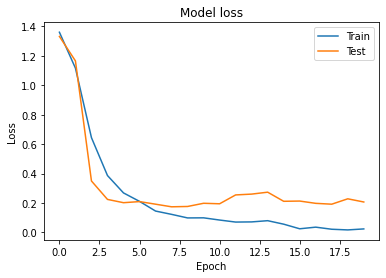

In [33]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Let's look at the last accuracy rate in terms of error.

In [34]:
train_err = (1-history.history['accuracy'][-1])*100
validation_err = (1-history.history['val_accuracy'][-1])*100
print("Train set error " + str(train_err))
print("Validation set error " + str(validation_err))

Train set error 0.669640302658081
Validation set error 5.113637447357178


#Prediction
Here we feed the test image set into the model.predict function and see how our model does.

In [35]:
test_datagen = ImageDataGenerator(samplewise_center = True,
                                 samplewise_std_normalization = True)

test_generator = test_datagen.flow(
    x = test_images,
    shuffle = False)

In [36]:
probabilities = model.predict(test_generator, steps = len(test_generator))
print(probabilities)
print(probabilities[:,0].mean()*100)
print(probabilities[:,1].mean()*100)
print(probabilities[:,2].mean()*100)
print(probabilities[:,3].mean()*100)

[[1.8712675e-04 2.1541875e-03 9.9761546e-01 4.3332468e-05]
 [4.4054279e-04 3.9174614e-04 9.9901617e-01 1.5152674e-04]
 [1.9979238e-04 2.8413837e-04 5.5978231e-05 9.9946004e-01]
 ...
 [1.1549161e-02 1.0462553e-02 9.7781837e-01 1.6998619e-04]
 [9.9993980e-01 9.3211156e-06 1.1870303e-05 3.9007547e-05]
 [8.7722969e-05 2.7256689e-04 1.2991906e-04 9.9950981e-01]]
22.00217843055725
5.795377865433693
40.50368368625641
31.69875741004944


In [37]:
valid_probabilities = model.predict(validation_generator, steps = len(validation_generator))
print(probabilities[:,0].mean()*100)
print(probabilities[:,1].mean()*100)
print(probabilities[:,2].mean()*100)
print(probabilities[:,3].mean()*100)

22.00217843055725
5.795377865433693
40.50368368625641
31.69875741004944


In [38]:
train_probabilities = model.predict(train_generator, steps = len(train_generator))
print(probabilities[:,0].mean()*100)
print(probabilities[:,1].mean()*100)
print(probabilities[:,2].mean()*100)
print(probabilities[:,3].mean()*100)

22.00217843055725
5.795377865433693
40.50368368625641
31.69875741004944


In [39]:
test = pd.read_csv('test.csv')
res = pd.DataFrame()
res['image_id'] = test['image_id']
res['healthy'] = probabilities[:, 0]
res['multiple_diseases'] = probabilities[:, 1]
res['rust'] = probabilities[:, 2]
res['scab'] = probabilities[:, 3]

In [40]:
res.to_csv('submission.csv', index=False)

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, valid_probabilities)

0.5514645099883153

# Fine Tuning the Model
Here we fine tune the model by unfreezing the layers in the pretrained model.

In [42]:
pre_trained.trainable = True
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2560)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               655616    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
Total params: 64,770,011
Trainable params: 64,459,284
Non-trainable params: 310,727
_________________________________________________________________


In [43]:
model.compile(
        loss = 'kullback_leibler_divergence', 
        optimizer = tf.keras.optimizers.Adam(1e-5), 
        metrics = ['accuracy'])

In [44]:
epochs = 10
history = model.fit(
    x = train_generator,  
    validation_data = validation_generator,
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    verbose=1)

Epoch 1/10
280/280 [==============================] - 108s 386ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 0.2491 - val_accuracy: 0.9545
Epoch 2/10
280/280 [==============================] - 103s 369ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.2715 - val_accuracy: 0.9432
Epoch 3/10
280/280 [==============================] - 103s 369ms/step - loss: 0.0220 - accuracy: 0.9937 - val_loss: 0.2645 - val_accuracy: 0.9432
Epoch 4/10
280/280 [==============================] - 104s 370ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.2572 - val_accuracy: 0.9375
Epoch 5/10
280/280 [==============================] - 103s 369ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.2459 - val_accuracy: 0.9375
Epoch 6/10
280/280 [==============================] - 103s 368ms/step - loss: 0.0106 - accuracy: 0.9978 - val_loss: 0.2049 - val_accuracy: 0.9545
Epoch 7/10
280/280 [==============================] - 103s 369ms/step - loss: 0.0114 - accuracy: 0.9969 - val_loss: 0.2506 -

In [45]:
probabilities = model.predict(test_generator, steps = len(test_generator))
print(probabilities)
print(probabilities[:,0].mean()*100)
print(probabilities[:,1].mean()*100)
print(probabilities[:,2].mean()*100)
print(probabilities[:,3].mean()*100)

[[4.7362703e-04 2.8625212e-03 9.9661821e-01 4.5635330e-05]
 [4.8080843e-04 3.3039809e-04 9.9899226e-01 1.9643961e-04]
 [1.2597194e-04 1.9115476e-05 2.1021911e-05 9.9983394e-01]
 ...
 [8.8274414e-03 1.3478289e-03 9.8981911e-01 5.6542649e-06]
 [9.9987304e-01 2.6533769e-05 1.5890129e-05 8.4476276e-05]
 [4.7166832e-05 5.3932785e-05 6.4770968e-05 9.9983418e-01]]
21.69918864965439
4.232122376561165
41.773781180381775
32.29491114616394


In [46]:
test = pd.read_csv('test.csv')
res = pd.DataFrame()
res['image_id'] = test['image_id']
res['healthy'] = probabilities[:, 0]
res['multiple_diseases'] = probabilities[:, 1]
res['rust'] = probabilities[:, 2]
res['scab'] = probabilities[:, 3]
res.to_csv('submission.csv', index=False)

In [47]:
train_err = (1-history.history['accuracy'][-1])*100
validation_err = (1-history.history['val_accuracy'][-1])*100
print("Train set error " + str(train_err))
print("Validation set error " + str(validation_err))

Train set error 0.1339256763458252
Validation set error 3.9772748947143555
